### POWER CONSUMPTION - Time Series Forecasting

In [5]:
# Import Libraries and Data set.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

# Load the dataset
df = pd.read_csv("household_power_consumption.csv", sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False)

# Filter necessary columns
df = df[['datetime', 'Global_active_power']]
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop missing values
df = df.dropna()

# Set datetime as index
df.set_index('datetime', inplace=True)

# Resample data to daily power consumption
df_daily = df.resample('D').sum()


C:\Users\itspr\AppData\Local\Temp\ipykernel_28980\3851824018.py:11: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.csv", sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False)
C:\Users\itspr\AppData\Local\Temp\ipykernel_28980\3851824018.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.csv", sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False)


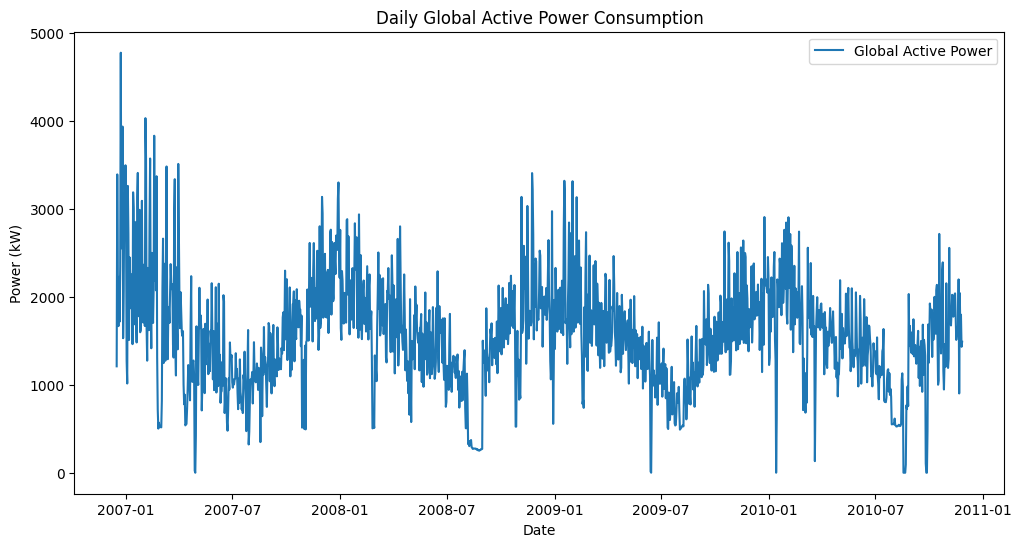

In [6]:
# Exploratory Data Analysis (EDA)

# power consumption over time
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['Global_active_power'], label='Global Active Power')
plt.title('Daily Global Active Power Consumption')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

In [7]:
# Feature Engineering

# Create lag and rolling features
df_daily['lag_1'] = df_daily['Global_active_power'].shift(1)
df_daily['lag_7'] = df_daily['Global_active_power'].shift(7)
df_daily['rolling_mean_7'] = df_daily['Global_active_power'].rolling(window=7).mean()
df_daily['rolling_std_7'] = df_daily['Global_active_power'].rolling(window=7).std()

# Drop NaN values after feature creation
df_daily = df_daily.dropna()

#### Model  Building

In [9]:
# SES Model
ses_model = SimpleExpSmoothing(df_daily['Global_active_power']).fit(smoothing_level=0.2, optimized=True)

# Forecast for next 30 days
forecast_ses = ses_model.forecast(steps=30)

c:\Users\itspr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [10]:
# ETS Model with Additive Trend and Seasonality
ets_model = ExponentialSmoothing(df_daily['Global_active_power'], trend="add", seasonal="add", seasonal_periods=7).fit()

# Forecast for next 30 days
forecast_ets = ets_model.forecast(steps=30)


c:\Users\itspr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [11]:
# ARIMA Model with order (p=5, d=1, q=0)
arima_model = ARIMA(df_daily['Global_active_power'], order=(5, 1, 0)).fit()

# Forecast for next 30 days
forecast_arima = arima_model.forecast(steps=30)

#### Model Evaluation 

In [12]:
# Define evaluation function
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Get actual data for the last 30 days
actual = df_daily['Global_active_power'][-30:]

# Evaluate each model
mae_ses, mse_ses, rmse_ses = evaluate_forecast(actual, forecast_ses[:30])
mae_ets, mse_ets, rmse_ets = evaluate_forecast(actual, forecast_ets[:30])
mae_arima, mse_arima, rmse_arima = evaluate_forecast(actual, forecast_arima[:30])

# Print results
print(f"SES -> MAE: {mae_ses:.2f}, MSE: {mse_ses:.2f}, RMSE: {rmse_ses:.2f}")
print(f"ETS -> MAE: {mae_ets:.2f}, MSE: {mse_ets:.2f}, RMSE: {rmse_ets:.2f}")
print(f"ARIMA -> MAE: {mae_arima:.2f}, MSE: {mse_arima:.2f}, RMSE: {rmse_arima:.2f}")


SES -> MAE: 276.31, MSE: 121989.02, RMSE: 349.27
ETS -> MAE: 272.44, MSE: 112750.93, RMSE: 335.78
ARIMA -> MAE: 297.50, MSE: 142894.82, RMSE: 378.01


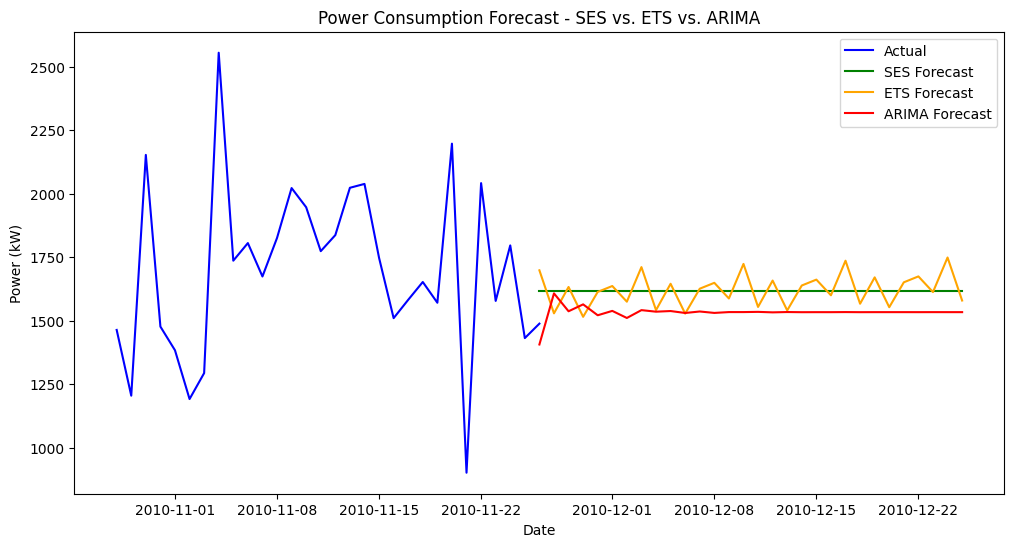

In [15]:
import matplotlib.pyplot as plt

# Generate 30 dates instead of 29 by not slicing with [1:]
forecast_dates = pd.date_range(df_daily.index[-1], periods=30, freq='D')

# Plot the actual vs. forecast for each model
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index[-30:], actual, label='Actual', color='blue')
plt.plot(forecast_dates, forecast_ses, label='SES Forecast', color='green')
plt.plot(forecast_dates, forecast_ets, label='ETS Forecast', color='orange')
plt.plot(forecast_dates, forecast_arima, label='ARIMA Forecast', color='red')

# Title and labels
plt.title('Power Consumption Forecast - SES vs. ETS vs. ARIMA')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()


## OBSERVATIONS 

- SES is inferior to ETS in all three metrics, confirming that SES is not capturing any trend or pattern in the data.
- ETS is the best model in this case, likely due to its ability to capture trend and/or seasonality better than SES or ARIMA. (Low - MSE and RMSE)